In [2]:
from modules.smpl_model._smpl import SMPL as SMPL_metro
from modules.utils.image_utils import plot_tensor, to_tensor, visualize_mesh
from modules.smpl_model.config_smpl import *
from modules.smpl_model.smpl_pose2mesh import SMPL

from modules.datasets.dataset_3DPW import get_data as get_data_3dpw
from modules.datasets.dataset_H36M import get_data as get_data_h36m
from modules.datasets.FullDataset import get_full_train_val_data
from modules.utils.data_utils_3dpw import get_chunks_img_paths_list_seq

from modules.smpl_model.smpl_pose2mesh import SMPL

In [3]:
import torch
import os.path as osp
import json
import copy
import numpy as np
import os
import pickle as pkl
from PIL import Image
import torch
import random

## SMPL Model Pose2Mesh

In [4]:
smpl = SMPL()
smpl_metro = SMPL_metro()

# Adapt Regressor for 10 PCs
smpl.layer['neutral'].th_shapedirs= smpl.layer['neutral'].th_shapedirs[:,:,:10]
smpl.layer['neutral'].th_betas= smpl.layer['neutral'].th_betas[:,:10]

## Dataset H36M

In [5]:
datah36m = get_data_h36m(data_path='../H36M',
                        subject_list = [11],
                        img_size=224,
                        load_datalist='../H36M/data_pickle/datalist_h36m_thr25_11to11subj.pickle', 
                        load_from_zarr=['../H36M/img_zarr/imgs_h36m_resnet_thr25_11to11subj.zarr'],
                        mask=True,
                        smpl=smpl.layer['neutral'],
                        backgrounds = None,
                        store_images=False)

In [6]:
loader_trn = torch.utils.data.DataLoader(
        dataset=datah36m,
        batch_size=1,
        shuffle=True,
    )

In [5]:
dat = datah36m[0]

In [6]:
img = dat['img']
img_path= dat['img_path']
verts = dat['vertices']
cam_pose =dat['cam_pose']
cam_intr = dat['cam_intr']
trans = dat['trans']

In [7]:
orig_img = np.array(Image.open(img_path))
orig_img = to_tensor(orig_img)

In [8]:
rend_img = visualize_mesh(orig_img, smpl=smpl_metro, cam_intr=cam_intr, vertices=(verts+trans)[None])
plot_tensor(rend_img)

NameError: name 'Renderer' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


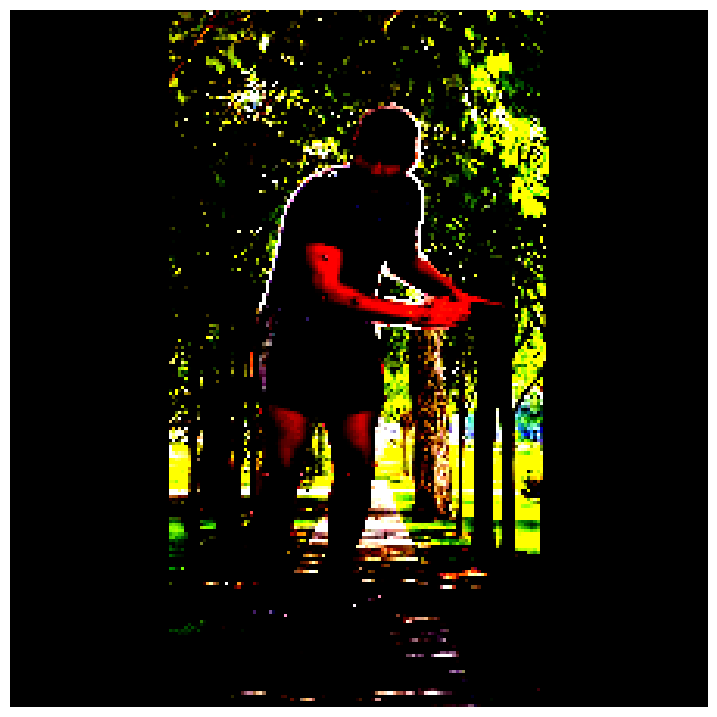

In [43]:
plot_tensor(img)

## Full Dataset

In [9]:
from modules.datasets.FullDataset import get_full_train_val_data

### Chunks 

In [13]:
import pickle as pkl

from modules.utils.image_utils import to_tensor, transform, transform_visualize, crop_box

from modules.datasets.dataset_seq_3DPW import SequenceWise3DPW
from modules.datasets.dataset_seq_H36M import SequenceWiseH36M
from modules.datasets.FullDataset import get_full_seq_train_val_data

In [58]:
data_h36m = SequenceWiseH36M(
            data_path='../H36M',
            subject_list=[9,11],
            smpl=smpl.layer['neutral'],
            load_from_zarr=None,
            load_seq_datalist='/Users/clara/Desktop/MeineProjekte/H36M/data_pickle/seq_datalist_h36m_thr25_9to11subj.pickle',
            load_datalist=None,
            len_chunks=8,
            img_size=224,
            mask= False,
            fitting_thr=25,
            store_images=False,
            backgrounds=None,
            )

In [59]:
data = data_h36m[1]

In [68]:
data_3dpw = SequenceWise3DPW(data_path='../3DPW',
        split='train',
        num_required_keypoints=8,
        smpl=smpl.layer['neutral'],
        len_chunks=8,
        store_sequences=True,
        store_images=False,
        load_from_zarr='/Users/clara/Desktop/MeineProjekte/3DPW/img_zarr/imgs_3dpw_train.zarr',
        img_size=224,
        load_chunks_seq='/Users/clara/Desktop/MeineProjekte/3DPW/data_pickle/img_seqs_list_paths_seq/img_seqs_list_paths_seq_train_min8_kps.pickle',
    )

In [ ]:
data = data_3dpw[0]

In [14]:
full_data = get_full_seq_train_val_data(
        dataset='full',
        data_path_3dpw='../3DPW',
        len_chunks=8,
        num_required_keypoints = 8,
        store_sequences=True,
        store_images_3dpw=True,
        load_from_zarr_3dpw_trn=None,
        load_from_zarr_3dpw_val=None,
        img_size=224,
        load_chunks_seq_trn='/Users/clara/Desktop/MeineProjekte/3DPW/data_pickle/img_seqs_list_paths_seq/img_seqs_list_paths_seq_train_min8_kps.pickle',
        load_chunks_seq_val='/Users/clara/Desktop/MeineProjekte/3DPW/data_pickle/img_seqs_list_paths_seq/img_seqs_list_paths_seq_validation_min8_kps.pickle',
        data_path_h36m='../H36M',
        store_images_h36m=False,
        load_from_zarr_h36m_trn=None,
        load_from_zarr_h36m_val=None,
        load_seq_datalist_trn='/Users/clara/Desktop/MeineProjekte/H36M/data_pickle/seq_datalist_h36m_thr25_9to11subj.pickle',
        load_seq_datalist_val='/Users/clara/Desktop/MeineProjekte/H36M/data_pickle/seq_datalist_h36m_thr25_9to11subj.pickle',
        backgrounds=None,
        mask=True,
        val_on_h36m=True,
        subject_list_trn=[9,11],
        subject_list_val=[9,11],
        fitting_thr=25,
    )

initialize smpl model
get 3dpw train data
get 3dpw validation data
get h36m train data
get h36m validation data
length train data: 3dpw: 2828, h36m: 9148, total: 11976
length validation data: 3dpw: 1294, h36m: 9148, total: 10442


In [15]:
train_data = full_data[0]
val_data= full_data[1]

In [8]:
data_loader = torch.utils.data.DataLoader(dataset=data.set_chunks(), 
                                        batch_size=batch_size_val, 
                                        shuffle=False,)

dict_keys(['img_paths', 'imgs', 'betas', 'poses', 'trans', 'vertices', 'cam_pose', 'cam_intr'])

In [12]:
val_data[0][1000].keys(),val_data[1][1000].keys()

(dict_keys(['img_paths', 'imgs', 'betas', 'poses', 'trans', 'vertices', 'cam_pose', 'cam_intr']),
 dict_keys(['img_paths', 'betas', 'poses', 'trans', 'vertices', 'cam_pose', 'cam_intr']))

In [16]:
def test(*args):
    for arg in args:
        print(arg)

In [21]:
test(*[1,2,3,4])#


(1, 2, 3, 4)
